## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Loading the Fahion MNIST dataset

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

Shuffling, slicing the dataset and converting into tensors.

In [3]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Function to encode the image into Example protocol buffer

In [4]:
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    return Example(
        features = Features(
        feature = {
            
            "image": Feature(bytes_list = BytesList(value = [image_data.numpy()])),
            "label": Feature(int64_list = Int64List(value = [label.numpy()]))
        }    
        ))

In [5]:
for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

write_tfrecords saves a given dataset to a set of TFRecord files. The examples are written to the files in a round-robin fashion. To do this, we enumerate all the examples using the `dataset.enumerate()` method, and we compute `index % n_shards` to decide which file to write to. We use `contextlib.ExitStack` class to make sure that all writers are properly closed whether or not an I/O erro occurs while writing.

In [6]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards = 10):
    paths = ["{}.tffrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
            for index in range(n_shards)]
    
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
        
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
            
    return paths

In [7]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid",valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

Reading from tfrecord files and creating the dataset ready for the training.

In [8]:
def preprocess(tfrecord):
    feature_description = {
        "image" : tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label" : tf.io.FixedLenFeature([], tf.int64, default_value = -1)
    }
    
    example = tf.io.parse_single_example(tfrecord, feature_description)
    image = tf.io.parse_tensor(example["image"], out_type = tf.uint8)
    image = tf.reshape(image, shape = [28,28])
    return image, example["label"]

def mnist_dataset(filepaths, n_read_threads = 5, shuffle_buffer_size = None,
                 n_parse_threads = 5, batch_size = 32, cache = True):
    
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads = n_read_threads)
    
    if cache:
        dataset = dataset.cache()
        
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
        
    dataset = dataset.map(preprocess, num_parallel_calls = n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [9]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size = 60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

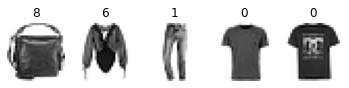

In [10]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(X[i].numpy(), cmap = "binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

standardization = keras.layers.experimental.preprocessing.Normalization(input_shape = [28,28])

sample_image_batches = train_set.take(100).map(lambda image, label :image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()), axis = 0).astype(np.float32)

standardization.adapt(sample_images)

model = keras.models.Sequential([
    
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(10, activation = "softmax")
])

model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = "nadam", metrics = ["accuracy"])

In [12]:
from datetime import datetime

logs = os.path.join(os.curdir, "my_logs", "run_"+datetime.now().strftime("%Y%m%d_%H%M%S"))

tensorboard_cb = tf.keras.callbacks.TensorBoard(
log_dir = logs, histogram_freq = 1, profile_batch = 10)

model.fit(train_set, epochs = 5, validation_data = valid_set, callbacks = [tensorboard_cb])

Epoch 1/5
      1/Unknown - 0s 0s/step - loss: 3.0446 - accuracy: 0.0312WARNING:tensorflow:From C:\Users\G Surya Krishna\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4429 - accuracy: 0.8415 - val_loss: 0.3990 - val_accuracy: 0.8600
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3348 - accuracy: 0.8780 - val_loss: 0.3299 - val_accuracy: 0.8790
Epoch 3/5
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2951 - accuracy: 0.8899 - val_loss: 0.3294 - val_accuracy: 0.8844
Epoch 4/5
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2700 - accuracy: 0.8993 - val_loss: 0.3397 - val_accuracy: 0.8830
Epoch 5/5
1719/1719 [==============================] - 2

In [15]:
#%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=8008

Reusing TensorBoard on port 8008 (pid 18224), started 0:00:31 ago. (Use '!kill 18224' to kill it.)